## Dynamic distance for quantum state diffusions

Let the inverse averaged covariance be
\begin{align}
 \Sigma^{-1}_{s,\left| \psi_1 \right>,\left| \psi_2 \right>} = 
\frac{1}{2}  \left( \Sigma^{-1}_{\left|\psi_1\right> } + \Sigma^{-1}_{\left|\psi_2\right> } \right) 
\end{align}
and 
\begin{align}
f(  \left|\psi_1\right>, \left|\psi_2\right>, \Sigma^{-1}_{s,\left| \psi_1 \right>,\left| \psi_2 \right>} ) 
=  \frac{\left|\left< \psi_1\right| \Sigma^{-1}_{s,\left| \psi_1 \right>,\left| \psi_2 \right>}\left| \psi_2 \right> \right| }
{
\sqrt{ \left|\left< \psi_1\right|  \Sigma^{-1}_{s,\left| \psi_1 \right>,\left| \psi_2 \right>} \left| \psi_1 \right> \right| }
\sqrt{ \left|\left< \psi_2\right|  \Sigma^{-1}_{s,\left| \psi_1 \right>,\left| \psi_2 \right>} \left| \psi_2 \right> \right| }
}.
\end{align}

I want to know if the following respects the triangle inequality:

\begin{align}
d_{\Sigma} (\left|\psi_1\right>,\left|\psi_2\right>)
= \text{acos} \left( 
f(  \left|\psi_1\right>, \left|\psi_2\right>, \Sigma^{-1}_{s,\left| \psi_1 \right>,\left| \psi_2 \right>} ) 
\right).
\end{align}


In [258]:
from scipy import random, linalg
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [439]:
dim = 3 ## make the dimension 3 for now.

In [441]:
def random_pos_def():
    '''
    random symmetric positive definite matrix.
    '''
    A = np.matrix([[random.normal(0,1) for i in range(dim)] for j in range(dim)])
    return np.asmatrix(np.dot(A,A.transpose()))

In [442]:
def real_random_vec():
    '''
    random real-valued vector.
    '''
    return np.asmatrix([random.normal(0,1) for i in range(dim)]).T

In [443]:
def random_vec(real_only=False):
    '''
    random vector with either complex or only real coordinates.
    '''
    if real_only==False:
        return (real_random_vec() + 1j* real_random_vec())
    else:
        return real_random_vec()

In [444]:
def my_inner_prod(x,y,cov_inv,eps = 1e-10):
    inner = abs(x.H * cov_inv * y) / np.sqrt( abs(x.H * cov_inv * x) * abs(y.H * cov_inv * y) )
    if inner > 1. and inner < 1. + eps:
        return 1. - eps
    return inner

In [445]:
def triangle_ineq(x,y,z,cov_inv_x,cov_inv_y,cov_inv_z):
    cov_xy = (cov_inv_x + cov_inv_y) / 2.
    cov_yz = (cov_inv_y + cov_inv_z) / 2.
    cov_xz = (cov_inv_x + cov_inv_z) / 2.
    inner_xz = my_inner_prod(x,z,cov_xz)
    inner_xy = my_inner_prod(x,y,cov_xy)
    inner_yz = my_inner_prod(y,z,cov_yz)
    return np.arccos ( inner_xz) <= np.arccos ( inner_xy ) + np.arccos (inner_yz )

In [446]:
def test_triangle():
    x,y,z = [random_vec() for i in range(3)]
    cov_inv_x,cov_inv_y,cov_inv_z = [random_pos_def() for i in range(3)]
    return triangle_ineq(x,y,z,cov_inv_x,cov_inv_y,cov_inv_z)

In [447]:
def validator(test = test_triangle, total = 1000):
    bool_list = []
    num_true = 0
    for i in range(total):
        bool_list.append(test())
        if bool_list[-1]:
            num_true +=1

    frac_true = float(num_true) / total
    return frac_true

In [448]:
print "percent true : %10.8f" % validator()

percent true : 0.96700000


## Result:

The triangle quality in general does not hold.

## Implications and other thoughts:

Since the triangle inequality isn't satisfied, the kernel may have negative eigenvalues. However, we have symmetry, so the eigenvalues are at least real. Further, we do not expect the covariance to change much for nearby points. I expect we might still be able to use the largest several eigenvectors and eigenvalues, which will likely be positive. This is similar to the situation in other dimensionality reduction methods when not using a true metric.

## What about the distance in Euclidean coordinates?

This is the distance mentioned in the paper: "Detecting the slow manifold by anisotropic diffusion maps" by
Amit Singer, Radek Erban, Ioannis G. Kevrekidis, Ronald R. Coifman

In [449]:
def Euclidean_distance(x,y,cov_inv):
    return np.sqrt((x-y).H*(cov_inv) * (x-y))

In [450]:
def triangle_ineq_Euclidean(x,y,z,cov_inv_x,cov_inv_y,cov_inv_z):
    cov_xy = (cov_inv_x + cov_inv_y) / 2.
    cov_yz = (cov_inv_y + cov_inv_z) / 2.
    cov_xz = (cov_inv_x + cov_inv_z) / 2.
    return Euclidean_distance(x,z,cov_xz) <= Euclidean_distance(x,y,cov_xy) + Euclidean_distance(y,z,cov_yz)

In [451]:
def test_triangle_Euclidean():
    x,y,z = [random_vec(real_only=True) for i in range(3)]
    cov_inv_x,cov_inv_y,cov_inv_z = [random_pos_def() for i in range(3)]
    return triangle_ineq_Euclidean(x,y,z,cov_inv_x,cov_inv_y,cov_inv_z)

In [452]:
print "percent true : %10.8f" % validator(test = test_triangle_Euclidean)

percent true : 0.92300000


## What happens as we change the dimension?

In [453]:
percents_my_distance = []
percents_Euclidean = []
max_dim = 20
dim_range = range(2,20)  ## I start at 2 because when dim == 1 all the quantum states are the same.
for dim in dim_range:
    percents_my_distance.append(validator())
    percents_Euclidean.append(validator(test = test_triangle_Euclidean))

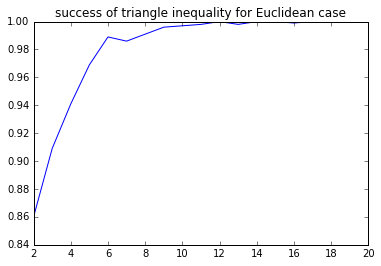

In [457]:
plt.plot( dim_range,percents_Euclidean)
plt.title("success of triangle inequality for Euclidean case")

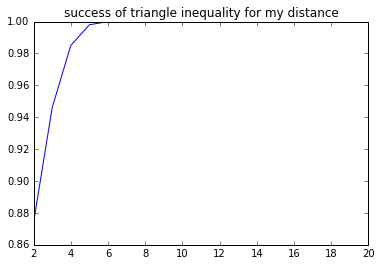

In [458]:
plt.plot( dim_range,percents_my_distance)
plt.title("success of triangle inequality for my distance")

## Comments:

Both versions converge to $1$ as the dimension grows. The distance I use converges about twice as fast. This makes sense because it's defined on complex coordiantes, so it has an equivalent of twice as many dimensions as the Euclidean case.